In [1]:
%pip install rosbags


[notice] A new release of pip is available: 23.3.1 -> 25.2
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Paths & params
BAG_DB3 = r"rosbag2_2025_10_16-00_08_43_0.db3"
ROBOT_NS = ["tb4_1", "tb4_2"]
DT_RESAMPLE = 0.05
OUTDIR = "qoc_out"

import os, json, sqlite3, numpy as np, pandas as pd
import matplotlib.pyplot as plt
os.makedirs(OUTDIR, exist_ok=True)
print("Bag path:", BAG_DB3)

Bag path: rosbag2_2025_10_16-00_08_43_0.db3


## Inspect bag (SQLite)

In [3]:
con = sqlite3.connect(BAG_DB3)
cur = con.cursor()
topics_df = pd.read_sql_query("SELECT id, name, type FROM topics", con)
stats_rows = []
for _, row in topics_df.iterrows():
    tid = row["id"]
    cnt, tmin, tmax = cur.execute(
        f"SELECT COUNT(*), MIN(timestamp), MAX(timestamp) FROM messages WHERE topic_id={tid}"
    ).fetchone()
    dur_s = (tmax - tmin)/1e9 if tmin is not None and tmax is not None and tmax>tmin else None
    rate = (cnt-1)/dur_s if dur_s and cnt and cnt>1 else None
    stats_rows.append({ "topic_id": tid, "topic": row["name"], "type": row["type"],
                        "count": cnt, "t_start_ns": tmin, "t_end_ns": tmax,
                        "duration_s": dur_s, "approx_rate_hz": rate })
bag_stats = pd.DataFrame(stats_rows).sort_values("topic").reset_index(drop=True)
con.close()
bag_stats

,topic_id,topic,type,count,t_start_ns,t_end_ns,duration_s,approx_rate_hz
0,1,/tb4_1/amcl_pose,geometry_msgs/msg/PoseWithCovarianceStamped,120,1760566130071715414,1760566331818929851,201.747214,0.589847
1,7,/tb4_1/imu,sensor_msgs/msg/Imu,6618,1760566136574498950,1760566335437992676,198.863494,33.274081
2,8,/tb4_1/odom,nav_msgs/msg/Odometry,3976,1760566136665740156,1760566335414001134,198.748261,20.000175
3,9,/tb4_1/scan,sensor_msgs/msg/LaserScan,1510,1760566136667939190,1760566335370403383,198.702464,7.594269
4,2,/tb4_2/amcl_pose,geometry_msgs/msg/PoseWithCovarianceStamped,104,1760566130070568737,1760566324636196392,194.565628,0.529384
5,3,/tb4_2/cmd_vel,geometry_msgs/msg/Twist,3180,1760566164602492306,1760566325550443328,160.947951,19.751727
6,4,/tb4_2/imu,sensor_msgs/msg/Imu,6838,1760566130058441751,1760566335432000635,205.373559,33.290556
7,5,/tb4_2/odom,nav_msgs/msg/Odometry,4105,1760566130075299560,1760566335432029342,205.356730,19.984736
8,6,/tb4_2/scan,sensor_msgs/msg/LaserScan,1604,1760566130099449197,1760566335386095366,205.286646,7.808594


## QoC pipeline (robust)

In [4]:
from pathlib import Path
try:
    from rosbags.highlevel import AnyReader
    from rosbags.typesys import get_typestore, Stores
except Exception as e:
    raise RuntimeError("Install `rosbags` (pip install rosbags)") from e

def make_typestore():
    for c in (Stores.ROS2_HUMBLE, Stores.ROS2_IRON, Stores.ROS2_JAZZY, Stores.ROS2_FOXY):
        try:
            return get_typestore(c)
        except Exception:
            continue
    return get_typestore(Stores.ROS2_HUMBLE)

def list_topics(reader):
    return sorted({c.topic for c in reader.connections})

def extract_odom(reader, topic_names):
    """Return dict: topic -> DataFrame[t, x, y, z, vx, vy, vz].
    Time t uses bag record timestamp (t_ns). Header stamp used only if strictly increasing and close to t_ns.
    """
    out = {}
    for topic in topic_names:
        conns = [c for c in reader.connections if c.topic == topic]
        if not conns:
            print(f"[WARN] topic missing: {topic}"); continue
        rows = []
        for conn in conns:
            for conn2, t_ns, raw in reader.messages(connections=[conn]):
                msg = reader.deserialize(raw, conn.msgtype)
                # default to bag time
                t = t_ns * 1e-9
                # optional: sanity-check header time
                try:
                    hs = msg.header.stamp.sec + 1e-9*msg.header.stamp.nanosec
                    if hs > 0 and abs(hs - t) < 1.0 and hs >= (rows[-1][0] if rows else -1e15):
                        t = hs
                except Exception:
                    pass
                x = msg.pose.pose.position.x
                y = msg.pose.pose.position.y
                z = msg.pose.pose.position.z
                vx = msg.twist.twist.linear.x
                vy = msg.twist.twist.linear.y
                vz = msg.twist.twist.linear.z
                rows.append((t,x,y,z,vx,vy,vz))
        if not rows:
            print(f"[WARN] no messages read for {topic}"); continue
        df = pd.DataFrame(rows, columns=["t","x","y","z","vx","vy","vz"])\
               .sort_values("t").drop_duplicates("t")
        out[topic] = df
    return out

def resample_to_common_time(trajs: dict, dt=0.05):
    # Build global grid from min start to max end
    tmin = min(df["t"].min() for df in trajs.values())
    tmax = max(df["t"].max() for df in trajs.values())
    if not np.isfinite(tmin) or not np.isfinite(tmax) or tmax <= tmin:
        raise SystemExit("Not enough temporal coverage to resample (check odometry counts).")
    t = np.arange(tmin, tmax + 0.5*dt, dt)
    out = {}
    for topic, df in trajs.items():
        tt = df["t"].to_numpy()
        # For each channel, if at least 2 samples: linear interp with edge hold; if 1 sample: constant fill
        def interp_col(col):
            yy = df[col].to_numpy()
            if np.sum(np.isfinite(yy)) >= 2 and len(tt) >= 2:
                # fill edges with nearest and interpolate inside
                yyf = np.interp(t, tt, yy, left=yy[0], right=yy[-1])
            else:
                # replicate single value or NaN-safe default 0
                val = yy[np.isfinite(yy)][0] if np.any(np.isfinite(yy)) else 0.0
                yyf = np.full_like(t, float(val))
            return yyf
        out[topic] = pd.DataFrame({
            "t": t,
            "x": interp_col("x"), "y": interp_col("y"), "z": interp_col("z"),
            "vx": interp_col("vx"), "vy": interp_col("vy"), "vz": interp_col("vz"),
        })
    return t, out

def compute_consensus_qoc(resampled: dict):
    topics = list(resampled.keys())
    if not topics:
        raise RuntimeError("No resampled data available.")
    times = resampled[topics[0]]["t"].to_numpy()
    X = np.vstack([resampled[tp]["x"].to_numpy() for tp in topics])
    Y = np.vstack([resampled[tp]["y"].to_numpy() for tp in topics])
    # Remove any rows with NaNs (shouldn't happen due to robust interp, but safe)
    mask = np.isfinite(X).all(axis=0) & np.isfinite(Y).all(axis=0)
    times = times[mask]; X = X[:,mask]; Y = Y[:,mask]
    if times.size < 2:
        raise SystemExit("Need at least 2 time samples after cleaning to compute QoC.")
    XC = X.mean(axis=0); YC = Y.mean(axis=0)

    Jc, Jc_norm, deltas2 = {}, {}, {}
    for i, tp in enumerate(topics):
        dx = X[i] - XC; dy = Y[i] - YC
        n2 = dx*dx + dy*dy
        J = np.trapz(n2, times)
        e0 = (dx[0]*dx[0] + dy[0]*dy[0])
        if not np.isfinite(e0) or e0 <= 1e-12:
            # use small positive baseline from early window
            e0 = float(np.nanmean(n2[:max(2, n2.size//10)]))
            if not np.isfinite(e0) or e0 <= 1e-12:
                e0 = 1.0
        Jn = J / e0
        Jc[tp] = float(J); Jc_norm[tp] = float(Jn); deltas2[tp] = n2

    Jn_vals = np.array(list(Jc_norm.values()), dtype=float)
    Jn_max = float(np.nanmax(Jn_vals)) if Jn_vals.size else 0.0
    if not np.isfinite(Jn_max) or Jn_max <= 0:
        Q = {tp: 0.0 for tp in topics}
        Jn_max = float(Jn_max) if np.isfinite(Jn_max) else 0.0
    else:
        Q = {tp: float((Jn_max - Jc_norm[tp]) / Jn_max) for tp in topics}

    df_ts = pd.DataFrame({"t": times, "xC": XC, "yC": YC})
    for i, tp in enumerate(topics):
        df_ts[f"{tp}:x"] = X[i]; df_ts[f"{tp}:y"] = Y[i]; df_ts[f"{tp}:delta2"] = deltas2[tp]

    summary = {"robots": topics, "Jc": Jc, "Jc_norm": Jc_norm, "Q": Q, "Jc_norm_max": Jn_max}
    return summary, df_ts


## Run pipeline

In [5]:
from pathlib import Path
bag_path = Path(BAG_DB3)
bag_dir = bag_path.parent if bag_path.is_file() else bag_path

typestore = make_typestore()
with AnyReader([bag_dir], default_typestore=typestore) as reader:
    available = list_topics(reader)
    topics = [f"/{ns}/odom" for ns in ROBOT_NS if f"/{ns}/odom" in available]
    if not topics:
        raise SystemExit(f"No /<ns>/odom topics among {ROBOT_NS}. Available (first 20): {available[:20]}")
    print("Using odom topics:", topics)
    trajs = extract_odom(reader, topics)

tvec, resampled = resample_to_common_time(trajs, dt=DT_RESAMPLE)
summary, df_ts = compute_consensus_qoc(resampled)

df_ts.to_csv(os.path.join(OUTDIR, "qoc_timeseries.csv"), index=False)
with open(os.path.join(OUTDIR, "qoc_summary.json"), "w") as f:
    json.dump(summary, f, indent=2)

print("=== QoC Summary ===")
for tp in summary["robots"]:
    print(f"{tp:20s}  Jc={summary['Jc'][tp]:.6f}  Jc_norm={summary['Jc_norm'][tp]:.6f}  Q={summary['Q'][tp]:.6f}")
print("Jc_norm_max:", summary["Jc_norm_max"])

Using odom topics: ['/tb4_1/odom', '/tb4_2/odom']
=== QoC Summary ===
/tb4_1/odom           Jc=55115.245582  Jc_norm=219.315715  Q=0.000000
/tb4_2/odom           Jc=55115.245582  Jc_norm=219.315715  Q=0.000000
Jc_norm_max: 219.31571487681845


## Plots

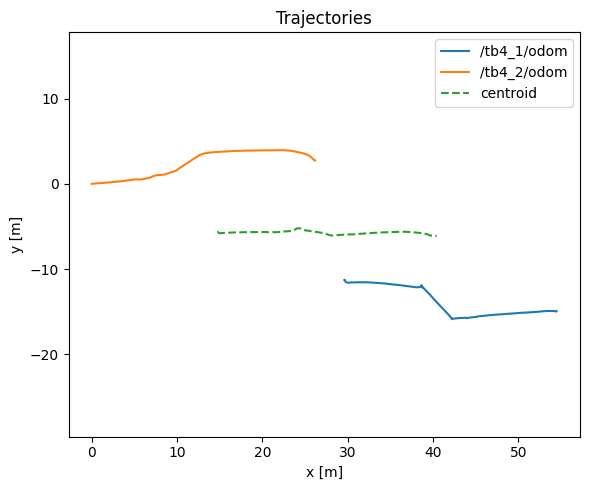

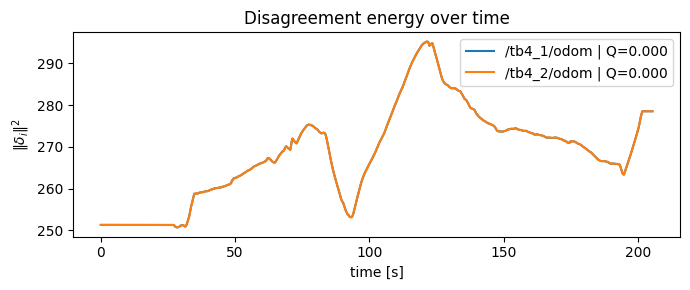

In [6]:
# Trajectories
plt.figure(figsize=(6,5))
for tp in summary["robots"]:
    plt.plot(df_ts[f"{tp}:x"], df_ts[f"{tp}:y"], label=tp)
plt.plot(df_ts["xC"], df_ts["yC"], linestyle="--", label="centroid")
plt.axis("equal"); plt.xlabel("x [m]"); plt.ylabel("y [m]"); plt.legend(); plt.title("Trajectories")
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, "trajectories.png"), dpi=200)
plt.show()

# Delta^2 over time
plt.figure(figsize=(7,3))
for tp in summary["robots"]:
    plt.plot(df_ts["t"] - df_ts["t"].iloc[0], df_ts[f"{tp}:delta2"], label=f"{tp} | Q={summary['Q'][tp]:.3f}")
plt.xlabel("time [s]"); plt.ylabel(r"$\|\delta_i\|^2$"); plt.legend(); plt.title("Disagreement energy over time")
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, "delta2_timeseries.png"), dpi=200)
plt.show()